In [199]:
import pandas as pd
import numpy as np

wine_dataset = pd.read_csv('WineQT.csv')
description = wine_dataset.describe()
print(description)

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000         

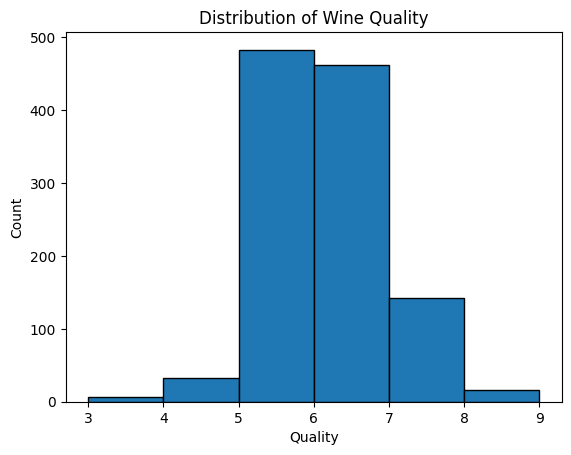

In [200]:
import matplotlib.pyplot as plt

plt.hist(wine_dataset['quality'], bins=range(3, 10), edgecolor='k')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Distribution of Wine Quality')
plt.show()

In [201]:
from sklearn.impute import SimpleImputer
from scipy import stats

imputer = SimpleImputer(strategy='mean')
wine_dataset = pd.DataFrame(imputer.fit_transform(wine_dataset), columns=wine_dataset.columns)

def winsorize_data(data, column_keys):
    winsorized_data = data.copy()
    for key in column_keys:
        winsorized_data[key] = stats.mstats.winsorize(data[key], limits=[0.01, 0.01])
    return winsorized_data

winsorized_data = winsorize_data(wine_dataset, wine_dataset.columns)
target = wine_dataset['quality']
features = wine_dataset.drop(['quality','Id'], axis=1)

# one-hot encoding the target for multi-nomial logistic regression
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
target = enc.fit_transform(target.values.reshape(-1, 1)).toarray()


In [202]:
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_val_standard = scaler.transform(X_val)
X_test_standard = scaler.transform(X_test)

# Normalize
min_max_scaler = MinMaxScaler()
X_train_normalized = min_max_scaler.fit_transform(X_train)
X_val_normalized = min_max_scaler.transform(X_val)
X_test_normalized = min_max_scaler.transform(X_test)


In [203]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

class MultinomialLogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / exp_z.sum(axis=1, keepdims=True)

    def initialize_params(self, num_features, num_classes):
        self.theta = np.zeros((num_features, num_classes))

    def predict(self, X):
        z = np.dot(X, self.theta)
        return np.argmax(self.softmax(z), axis=1)

    def cross_entropy_loss(self, X, y):
        m = X.shape[0]
        z = np.dot(X, self.theta)
        predicted_probabilities = self.softmax(z)
        loss = -np.sum(np.log(predicted_probabilities[range(m), np.argmax(y, axis=1)])) / m
        return loss

    def fit(self, X, y):
        m, n = X.shape
        num_classes = y.shape[1]
        self.initialize_params(n, num_classes)

        for i in range(self.num_iterations):
            z = np.dot(X, self.theta)
            predicted_probabilities = self.softmax(z)
            gradient = -np.dot(X.T, (y - predicted_probabilities)) / m
            self.theta -= self.learning_rate * gradient

    def train(self, X_train, y_train, X_val, y_val):
        self.fit(X_train, y_train)

        train_loss = self.cross_entropy_loss(X_train, y_train)
        val_loss = self.cross_entropy_loss(X_val, y_val)

        return train_loss, val_loss


In [204]:
def gradient_descent(X, y, learning_rate, num_iterations):
    m, n = X.shape
    theta = np.zeros(n)
    for i in range(num_iterations):
        z = np.dot(X, theta)
        predicted_probabilities = 1 / (1 + np.exp(-z))
        gradient = np.dot(X.T, predicted_probabilities - y) / m
        theta -= learning_rate * gradient
    return theta


In [205]:

model = MultinomialLogisticRegression(learning_rate=0.01, num_iterations=1000)

train_loss, val_loss = model.train(X_train, y_train, X_val, y_val)

y_val_pred = model.predict(X_val)

val_accuracy = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)

print("Validation Set Metrics:")
print(classification_report(np.argmax(y_val, axis=1), y_val_pred))

print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Validation Set Metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         6
           2       0.42      0.78      0.54        63
           3       0.00      0.00      0.00        80
           4       0.20      0.48      0.28        27
           5       0.00      0.00      0.00         5

    accuracy                           0.34       183
   macro avg       0.10      0.21      0.14       183
weighted avg       0.17      0.34      0.23       183

Train Loss: 3.0512
Validation Loss: 3.7685
Validation Accuracy: 33.88%


/home/manohar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manohar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manohar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [206]:
import wandb

wandb.init(project="your-project-name", config={
    "learning_rate": 0.01,  
    "epochs": 1000  
})

learning_rate = wandb.config.learning_rate
epochs = wandb.config.epochs

for epoch in range(epochs):
    train_loss, val_loss = model.train(X_train, y_train, X_val, y_val)
    wandb.log({"train_loss": train_loss, "val_loss": val_loss})


y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)

print("Test Set Metrics:")
print(classification_report(np.argmax(y_test, axis=1), y_test_pred))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,3.05119
val_loss,3.76847


Test Set Metrics:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.48      0.75      0.58        96
           3       0.00      0.00      0.00        99
           4       0.15      0.46      0.23        26
           5       0.00      0.00      0.00         2

    accuracy                           0.37       229
   macro avg       0.13      0.24      0.16       229
weighted avg       0.22      0.37      0.27       229

Test Accuracy: 36.68%


/home/manohar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manohar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manohar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
